# Basic Hierarchical Clustering Python

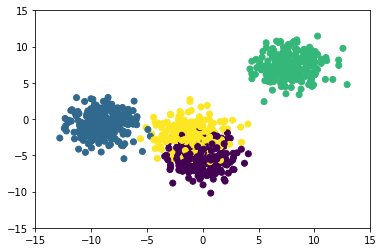

In [2]:
# Create fake data
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# create blobs
data = make_blobs(n_samples=1000, n_features=100, centers=4, cluster_std=1.6, random_state=50)
matrix = pd.DataFrame(data[0].T)
true_classes = data[1]
# create scatter plot
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

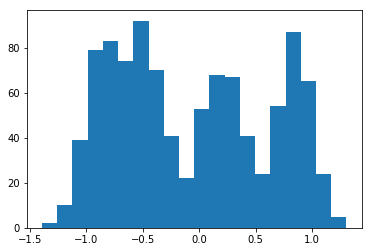

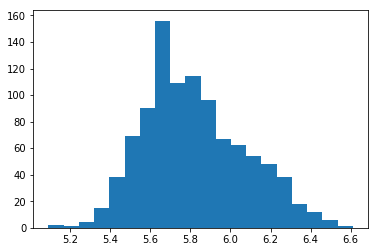

In [3]:
import matplotlib.pyplot as plt
plt.hist(np.mean(matrix,axis=0),bins=20)
plt.show()
plt.hist(np.std(matrix,axis=0),bins=20)
plt.show()

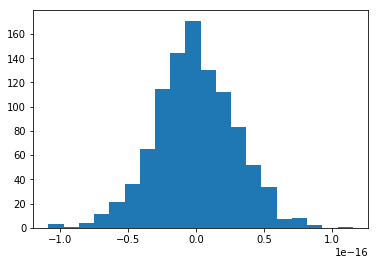

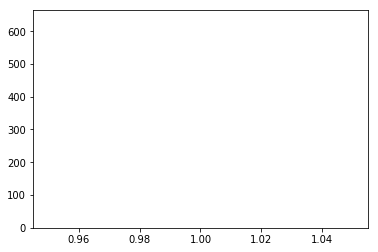

In [4]:
# Center and Scale data
# Mean to 0 std to 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_matrix = StandardScaler().fit_transform(matrix)
plt.hist(np.mean(standardized_matrix,axis=0),bins=20)
plt.show()
plt.hist(np.std(standardized_matrix,axis=0),bins=20)
plt.show()

In [5]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(standardized_matrix.T)
pca_matrix = pd.DataFrame(principalComponents)

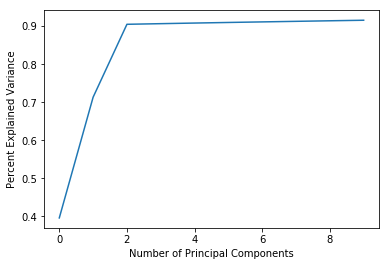

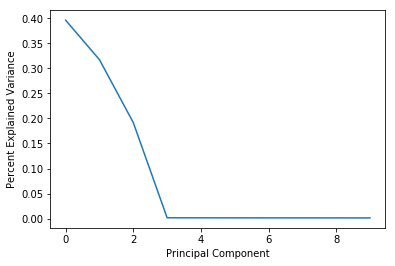

In [6]:
# Scree plot
plt.plot(range(10),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Percent Explained Variance')
plt.show()
plt.plot(range(10),pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Percent Explained Variance')
plt.show()

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


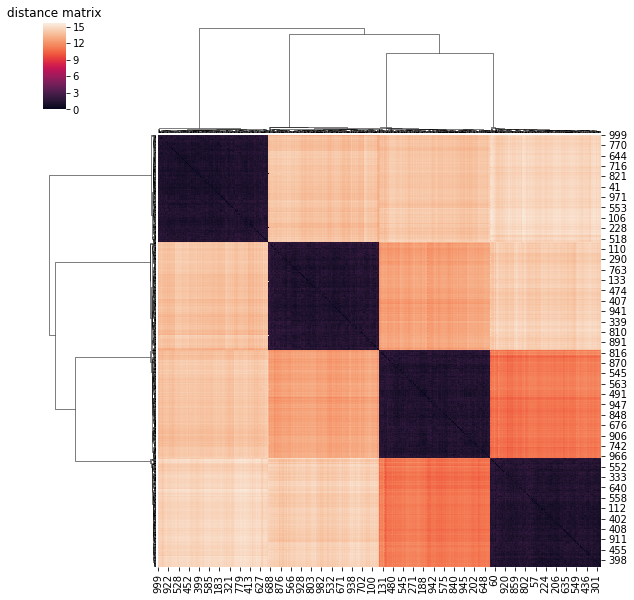

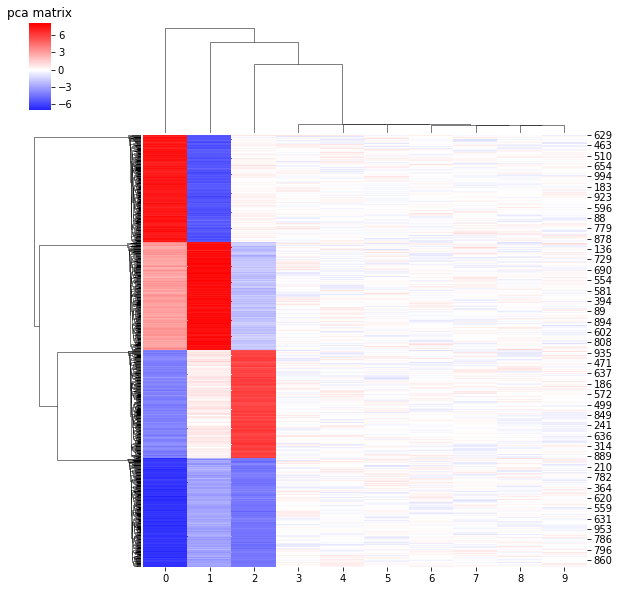

In [7]:
from scipy.spatial import distance_matrix
import seaborn as sns
pca_distance_matrix = distance_matrix(pca_matrix,pca_matrix)
sns.clustermap(pca_distance_matrix)
plt.title('distance matrix')
plt.show()
sns.clustermap(pca_matrix,cmap='bwr',center=0)
plt.title('pca matrix')
plt.show()

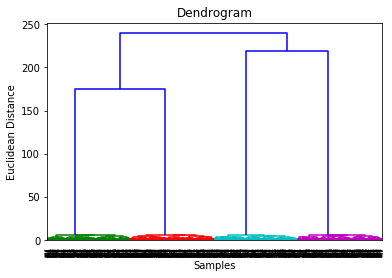

In [8]:
import scipy.cluster.hierarchy as sch
# Calculate linkage
linkage = sch.linkage(pca_matrix, method  = "ward",metric='euclidean')
# Build dendrogram
# Cluster by max distance
dendrogram = sch.dendrogram(linkage)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance')
plt.show()

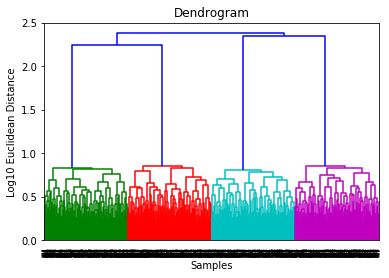

In [9]:
log_linkage = linkage.copy()
log_linkage[:,2] = np.log10(log_linkage[:,2]+1)
dendrogram = sch.dendrogram(log_linkage)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Log10 Euclidean Distance')
plt.show()

In [10]:
# Each node is made of 2 parts (either a sample(leaf) or another node)
# part1, part 2, distance, group
"""
Convert to cell type by node matrix
"""
from ipypb import ipb
def find_next_node(i,df):
    temp = df[(df[0]==i)|(df[1]==i)]
    if len(temp)==1:
        return int(temp[4].iloc[0])
    else:
        return 'False'
def linkage2binary(linkage):
    nnodes = len(linkage)
    nsamples = len(linkage)+1
    linkage_df = pd.DataFrame(np.concatenate((linkage,nsamples+np.array(range(linkage.shape[0]))[:,None]),axis=1))
    binary_node_matrix = np.zeros((nsamples,nnodes+nsamples))
    for sample in ipb(range(nsamples),nsamples):
        new_node = sample
        while isinstance(new_node,int):
            binary_node_matrix[sample,new_node]=1
            new_node = find_next_node(new_node,linkage_df)
    binary_node_df = pd.DataFrame(binary_node_matrix)
    distances = np.concatenate((np.zeros(nsamples),linkage[:,2]),axis=0)
    return binary_node_df,distances
binary_node_df,distances = linkage2binary(linkage)

 [████████████████████████████████████████████████████████████] 1000/1000 [00:17<00:00, 0.02s/it]

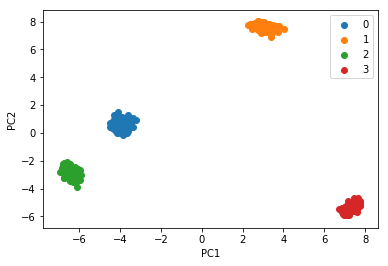

In [16]:
# Set distance threshold (Very sensitive)
d = 5.75
clusters = []
for i,row in binary_node_df[binary_node_df.columns[distances>d]].iterrows():
    clusters.append(np.min(row[row==1].index))
for i,cluster in enumerate(np.unique(clusters)):
    mask = clusters==cluster
    plt.scatter(pca_matrix[0][mask],pca_matrix[1][mask],label=i)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()
# doesnt look great bc only looking at 2 PCs

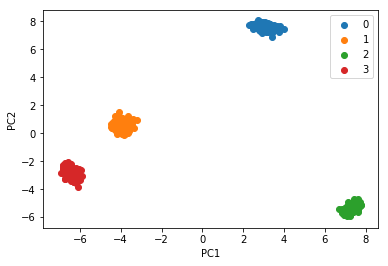

In [12]:
# Specifying the number of clusters
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
clusters = hc.fit_predict(pca_matrix)
for cluster in np.unique(clusters):
    mask = clusters==cluster
    plt.scatter(pca_matrix[0][mask],pca_matrix[1][mask],label=cluster)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()
# doesnt look great bc only looking at 2 PCs

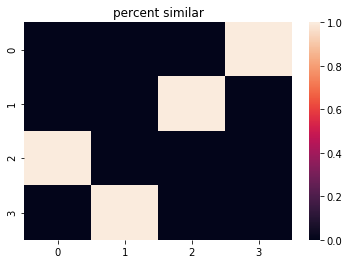

In [15]:
# Confusion Matrix
confusion_matrix = np.zeros([len(np.unique(true_classes)),len(np.unique(clusters))])
for i,tc in enumerate(np.unique(true_classes)):
    true_mask = (true_classes==tc)
    for j,nc in enumerate(np.unique(clusters)):
        shared = np.sum(true_mask&(clusters==nc))
        if shared>0:
            confusion_matrix[i,j] = shared/np.sum(true_mask)
confusion_matrix = pd.DataFrame(confusion_matrix,columns=np.unique(true_classes),index=np.unique(clusters))
sns.heatmap(confusion_matrix)
plt.title('percent similar')
plt.show()